In [39]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.transforms
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import numpy as np
from keypoint_detection.utils.heatmap import gaussian_heatmap, generate_keypoints_heatmap, overlay_image_with_heatmap, get_keypoints_from_heatmap
from keypoint_detection.models.models import KeypointDetector
from keypoint_detection.data.datamodule import BoxKeypointsDataModule
from keypoint_detection.data.dataset import  BoxKeypointsDataset, BoxDatasetPreloaded, BoxDatasetIOCatcher

In [24]:
import wandb
from pathlib import Path
from skimage import io
import torchvision

In [9]:

# reference can be retrieved in artifacts panel
# "VERSION" can be a version (ex: "v2") or an alias ("latest or "best")
checkpoint_reference = "airo-box-manipulation/test-project/model-3lcswr74:latest"

# download checkpoint locally (if not already cached)
run = wandb.init(project="test-project", entity="airo-box-manipulation")
artifact = run.use_artifact(checkpoint_reference, type="model")
artifact_dir = artifact.download()

# load checkpoint
model = KeypointDetector.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", backbone= "DilatedCnn")

In [20]:

img = io.imread("/home/tlips/Onedrive_UGent/A-PHD/Box-manipulation/2021_12_09/box2/6_Color.png")
transform = torchvision.transforms.ToTensor()
img_t = transform(img)
img_t = img_t.unsqueeze(0)
img_t.shape


torch.Size([1, 3, 480, 640])

In [32]:
with torch.no_grad():
    output = model(img_t)
output.shape

torch.Size([1, 2, 480, 640])

In [29]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()


torch.Size([1, 3, 480, 640])
torch.Size([1, 2, 480, 640])


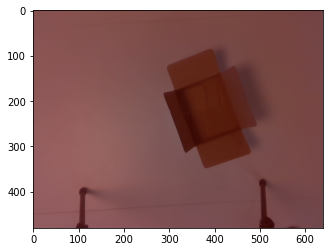

In [50]:
print(img_t.shape)
print(output.shape)
output_img = overlay_image_with_heatmap(img_t[0],output[0][0].unsqueeze(0))
plt.imshow(output_img)